In [21]:
import pandas	 as pd
import numpy	 as np
import matplotlib.pyplot as plt
import seaborn	 as sns
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.subplots as sp
import plotly.express as px
import plotly.figure_factory as ff
import plotly.subplots as sp
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv(r"C:\Users\vibhu\Downloads\MSc 4th semester\ATM cash relenishment model\project 100atm\merged_atm_data.csv")
df.head()




df.columns
df.info()
# Check for missing values
df.isnull().sum()
df.head(10)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_name()
df['Week'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter
df['is_weekend'] = df['Weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
df['is_weekday'] = df['Weekday'].apply(lambda x: 1 if x not in ['Saturday', 'Sunday'] else 0)
df['is_holiday'] = df['Weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
df['is_holiday'] = df['is_holiday'].astype(int)

df.head()
df.drop(columns=['Year', 'Month', 'Week', 'Quarter'], inplace=True)
df.head()



# Convert categorical columns to category type
df['ATM_ID'] = df['ATM_ID'].astype('category')
# Identify salary dates (assuming salaries are credited on the 1st to 8 of every month)
df['is_salary_day'] = np.where(df['Date'].dt.day <= 8, 1, 0)
# Check if salary dates are identified correctly
print(df[['Date', 'is_salary_day']].head())

# 2. Holiday Data
holiday_df= pd.read_csv(r'C:\Users\vibhu\Downloads\MSc 4th semester\ATM cash relenishment model\project 100atm\festivals.csv')
holiday_df.head()
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'], format='%Y-%m-%d', errors='coerce')
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'], format='%Y-%m-%d', errors='coerce')


# Ensure 'Date' column in holiday_df is in datetime format
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'], format='%Y-%m-%d', errors='coerce')

# Merge datasets on the date column
df = df.merge(holiday_df, how='left', left_on='Date', right_on='Date')

# Fill missing values (for non-holiday days)
df['Festival Name'].fillna("No Holiday", inplace=True)

# Create a binary holiday feature
df['is_holiday'] = (df['Festival Name'] != "No Holiday").astype(int)

print(df[['Date', 'Festival Name', 'is_holiday']].head())

df.head()
# 3. Monthly Transaction Trends

# Ensure the 'Month' column exists
df['Month'] = df['Date'].dt.month

# Calculate monthly transaction trends
monthly_trends = df.groupby('Month')['Transaction_Amount'].sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9521319 entries, 0 to 9521318
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ATM_ID              object 
 1   Bank_Name           object 
 2   Neighborhood        object 
 3   ATM_Type            object 
 4   Latitude            float64
 5   Longitude           float64
 6   Area_Type           object 
 7   Landmark            object 
 8   Date                object 
 9   Day                 object 
 10  Time                object 
 11  Transaction_Type    object 
 12  Transaction_Amount  int64  
 13  Remaining_Cash      int64  
 14  Cash_Refill         object 
 15  Transaction_Status  object 
 16  Festival            object 
dtypes: float64(2), int64(2), object(13)
memory usage: 1.2+ GB
        Date  is_salary_day
0 2024-01-01              1
1 2024-01-01              1
2 2024-01-01              1
3 2024-01-01              1
4 2024-01-01              1


C:\Users\vibhu\AppData\Local\Temp\ipykernel_8488\3079952511.py:67: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





        Date Festival Name  is_holiday
0 2024-01-01    No Holiday           0
1 2024-01-01    No Holiday           0
2 2024-01-01    No Holiday           0
3 2024-01-01    No Holiday           0
4 2024-01-01    No Holiday           0


            Transaction_Amount  is_salary_day  is_holiday
Date                                                     
2024-01-01           268787200          20833           0
2024-01-02           285805400          22109           0
2024-01-03           278749100          21601           0
2024-01-04           277596900          21549           0
2024-01-05           268912700          20818           0


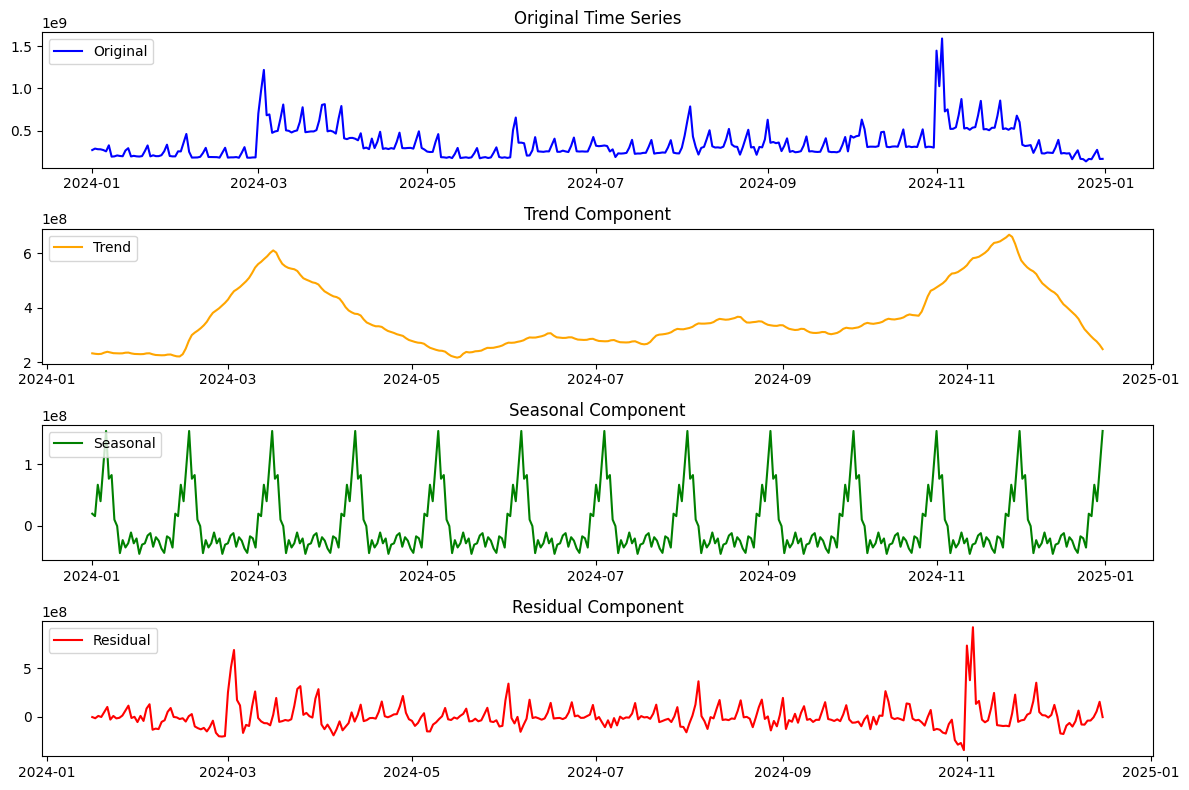

In [22]:
# Ensure 'Date' is the index for time series modeling
if 'Date' not in df.index.names:
	df.set_index("Date", inplace=True)

# Keep only necessary columns
time_series_data = df[['Transaction_Amount', 'is_salary_day', 'is_holiday']]

# Resample daily to ensure no missing dates
time_series_data = time_series_data.resample('D').sum()

# Check final dataset
print(time_series_data.head())

from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(time_series_data['Transaction_Amount'], model='additive', period=30)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(time_series_data['Transaction_Amount'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(residual, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()




ADF Statistic: -2.690243158951738
p-value: 0.07574189977895643
Critical Values:
   1%: -3.449226932880019
   5%: -2.869857365438656
   10%: -2.571201085130664
Fail to reject the null hypothesis (series is non-stationary)


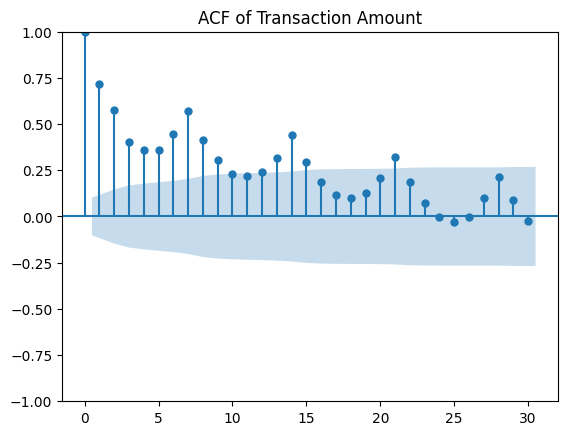

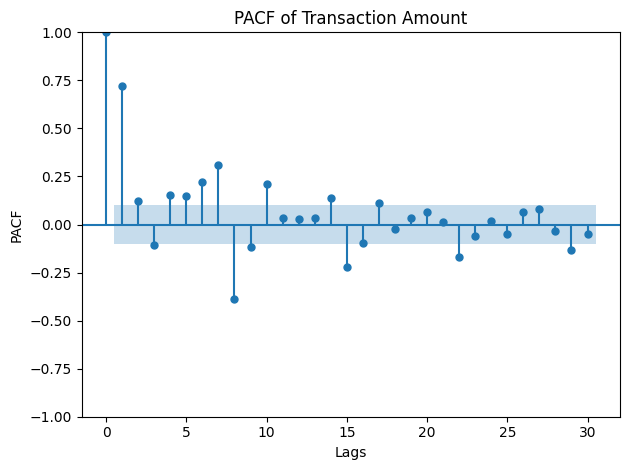

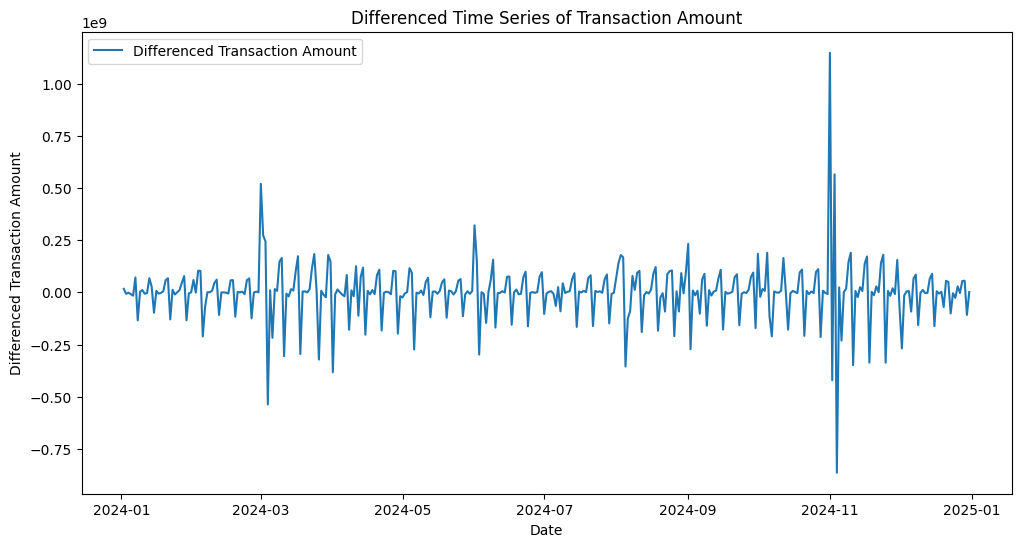

ADF Statistic: -5.954805284079538
p-value: 2.1055603949379332e-07
Critical Values:
   1%: -3.449226932880019
   5%: -2.869857365438656
   10%: -2.571201085130664
Reject the null hypothesis (series is stationary)


In [23]:
# adf test for stationarity
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
	result = adfuller(series)
	print('ADF Statistic:', result[0])
	print('p-value:', result[1])
	print('Critical Values:')
	for key, value in result[4].items():
		print(f'   {key}: {value}')
	# Interpret the result
	if result[1] <= 0.05:
		print("Reject the null hypothesis (series is stationary)")
	else:
		print("Fail to reject the null hypothesis (series is non-stationary)")	



# Perform ADF test on the time series data
adf_test(time_series_data['Transaction_Amount'])
# Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# Compute ACF and PACF values
acf_values = acf(time_series_data['Transaction_Amount'], nlags=30, fft=True)
pacf_values = pacf(time_series_data['Transaction_Amount'], nlags=30)

plot_acf(time_series_data['Transaction_Amount'], lags=30)	

plt.title('ACF of Transaction Amount')
plt.show()

plot_pacf(time_series_data['Transaction_Amount'], lags=30)
plt.title('PACF of Transaction Amount')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.tight_layout()
plt.show()

# Apply first-order differencing to make the series stationary
time_series_data['Differenced_Transaction_Amount'] = time_series_data['Transaction_Amount'].diff()

# Drop NaN values resulting from differencing
differenced_series = time_series_data['Differenced_Transaction_Amount'].dropna()
# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(differenced_series, label='Differenced Transaction Amount')
plt.title('Differenced Time Series of Transaction Amount')
plt.xlabel('Date')
plt.ylabel('Differenced Transaction Amount')
plt.legend()
plt.show()

# Perform ADF test on the differenced series
adf_test(differenced_series)



In [24]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the exogenous variables
exog_variables = time_series_data[['is_salary_day', 'is_holiday']]

# Fit auto ARIMA model with exogenous variables
Auto_arima_model = auto_arima(
	time_series_data['Transaction_Amount'], 
	exogenous=exog_variables, 
	seasonal=True, 
	m=7
)

# Fit SARIMAX Model with exogenous variables
Sarimax_model = SARIMAX(
	time_series_data['Transaction_Amount'], 
	order=(1, 1, 1), 
	seasonal_order=(1, 1, 1, 7), 
	exog=exog_variables
)
Sarimax_model_fit = Sarimax_model.fit()

# Print model summaries
print("Auto ARIMA Model Summary:")
print(Auto_arima_model.summary())
print("\nSARIMAX Model Summary:")
print(Sarimax_model_fit.summary())

c:\Users\vibhu\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\vibhu\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\vibhu\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\vibhu\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\vibhu\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\vibhu\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: Fu

Auto ARIMA Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  366
Model:             SARIMAX(2, 0, 3)x(1, 0, [1], 7)   Log Likelihood               -7264.573
Date:                             Thu, 24 Apr 2025   AIC                          14547.147
Time:                                     13:53:46   BIC                          14582.270
Sample:                                 01-01-2024   HQIC                         14561.104
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.148e+07   2.53e-09   2.03e+16      0.000    5.15e+07    5.15e+07
a

In [25]:
import plotly.graph_objects as go

# Predict January 2025 using both models
# Create exogenous variables for January 2025
january_2025_exog = pd.DataFrame({
	'is_salary_day': [1 if day <= 8 else 0 for day in range(1, 32)],
	'is_holiday': [0] * 31  # Assuming no holidays in January 2025; update if needed
})

# Predict January 2025 using both models
january_2025_forecast = pd.DataFrame({
	'Date': pd.date_range(start='2025-01-01', end='2025-01-31', freq='D'),
	'Auto_ARIMA_Forecast': Auto_arima_model.predict(n_periods=31),
	'SARIMAX_Forecast': Sarimax_model_fit.get_forecast(steps=31, exog=january_2025_exog).predicted_mean
})

# Create a comparison graph for two-year transaction amounts and predictions
fig = go.Figure()

# Add actual transaction amounts for 2023 and 2024
fig.add_trace(go.Scatter(
	x=time_series_data.index,
	y=time_series_data['Transaction_Amount'],
	mode='lines',
	name='Actual Transactions (2023-2024)',
	line=dict(color='green')
))

# Add Auto ARIMA predictions for January 2025
fig.add_trace(go.Scatter(
	x=january_2025_forecast['Date'],
	y=january_2025_forecast['Auto_ARIMA_Forecast'],
	mode='lines+markers',
	name='Auto ARIMA Predictions (Jan 2025)',
	line=dict(color='blue')
))

# Add SARIMAX predictions for January 2025
fig.add_trace(go.Scatter(
	x=january_2025_forecast['Date'],
	y=january_2025_forecast['SARIMAX_Forecast'],
	mode='lines+markers',
	name='SARIMAX Predictions (Jan 2025)',
	line=dict(color='red')
))

# Customize the layout
fig.update_layout(
	title='Comparison of Two-Year Transactions and January 2025 Predictions',
	xaxis_title='Date',
	yaxis_title='Transaction Amount',
	legend_title='Legend',
	template='plotly_white'
)

# Show the graph
fig.show()

c:\Users\vibhu\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\vibhu\miniconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [26]:
import plotly.graph_objects as go

# Ensure 'fitted_values' is defined
if 'fitted_values' not in locals():
	fitted_values = Sarimax_model_fit.predict(start=0, end=len(time_series_data)-1)

# Create the comparison DataFrame
comparison_df = pd.DataFrame({
	'Date': time_series_data.index,
	'Actual': time_series_data['Transaction_Amount'],
	'Predicted': fitted_values
}).reset_index(drop=True)

# Create a figure
fig = go.Figure()

# Add the actual data line
fig.add_trace(go.Scatter(
	x=comparison_df['Date'],
	y=comparison_df['Actual'],
	mode='lines',
	name='Actual',
	line=dict(color='blue')
))

# Add the SARIMAX predicted data line
fig.add_trace(go.Scatter(
	x=comparison_df['Date'],
	y=comparison_df['Predicted'],
	mode='lines',
	name='SARIMAX Predicted',
	line=dict(color='red')
))

# Add the January 2025 predictions
fig.add_trace(go.Scatter(
	x=january_2025_forecast['Date'],
	y=january_2025_forecast['SARIMAX_Forecast'],
	mode='lines+markers',
	name='January 2025 Predictions',
	line=dict(color='green', dash='dash')
))

# Customize the layout
fig.update_layout(
	title='Actual vs SARIMAX Predicted Transaction Amounts (Including January 2025)',
	xaxis_title='Date',
	yaxis_title='Transaction Amount',
	legend_title='Legend',
	template='plotly_white'
)

# Show the plot
fig.show()


In [27]:
import plotly.graph_objects as go

# Predict January 2025 using both models
# Create exogenous variables for January 2025
january_2025_exog = pd.DataFrame({
	'is_salary_day': [1 if day <= 8 else 0 for day in range(1, 32)],
	'is_holiday': [0] * 31  # Assuming no holidays in January 2025; update if needed
})

# Predict January 2025 using both models
january_2025_forecast = pd.DataFrame({
	'Date': pd.date_range(start='2025-01-01', end='2025-01-31', freq='D'),
	'Auto_ARIMA_Forecast': Auto_arima_model.predict(n_periods=31),
	'SARIMAX_Forecast': Sarimax_model_fit.get_forecast(steps=31, exog=january_2025_exog).predicted_mean
})

# Create a comparison graph
fig = go.Figure()

# Add Auto ARIMA predictions
fig.add_trace(go.Scatter(
	x=january_2025_forecast['Date'],
	y=january_2025_forecast['Auto_ARIMA_Forecast'],
	mode='lines+markers',
	name='Auto ARIMA Predictions',
	line=dict(color='blue')
))

# Add SARIMAX predictions
fig.add_trace(go.Scatter(
	x=january_2025_forecast['Date'],
	y=january_2025_forecast['SARIMAX_Forecast'],
	mode='lines+markers',
	name='SARIMAX Predictions',
	line=dict(color='red')
))

# Customize the layout
fig.update_layout(
	title='Comparison of January 2025 Predictions: Auto ARIMA vs SARIMAX',
	xaxis_title='Date',
	yaxis_title='Transaction Amount',
	legend_title='Model',
	template='plotly_white'
)

# Show the graph
fig.show()

c:\Users\vibhu\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\vibhu\miniconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [28]:
# Define the holidays and their dates
holidays_2025 = pd.DataFrame({
	'Date': pd.to_datetime(['2025-01-14', '2025-02-27', '2025-03-13', '2025-03-14', '2025-03-31']),
	'Holiday': ['Makar Sankranti', 'Maha Shivratri', 'Holika Dahan', 'Holi', 'Eid-ul-Fitr']
})

# Create exogenous variables for January to March 2025
january_to_march_2025_exog = pd.DataFrame({
	'is_salary_day': [1 if day <= 8 else 0 for day in range(1, 32)] + 
					 [1 if day <= 8 else 0 for day in range(1, 29)] + 
					 [1 if day <= 8 else 0 for day in range(1, 32)],
	'is_holiday': [1 if pd.Timestamp(f'2025-{month:02d}-{day:02d}') in holidays_2025['Date'].values else 0 
				   for month, days in zip([1, 2, 3], [31, 28, 31]) for day in range(1, days + 1)]
})

# Ensure 'Date' column exists in the exogenous variables DataFrame
january_to_march_2025_exog['Date'] = pd.date_range(start='2025-01-01', end='2025-03-31', freq='D')

# Predict January to March 2025 using the SARIMAX model
january_to_march_2025_forecast = pd.DataFrame({
	'Date': pd.date_range(start='2025-01-01', end='2025-03-31', freq='D'),
	'SARIMAX_Forecast': Sarimax_model_fit.get_forecast(steps=90, exog=january_to_march_2025_exog[['is_salary_day', 'is_holiday']]).predicted_mean
})

# Create a comparison graph
fig = go.Figure()

# Add SARIMAX predictions
fig.add_trace(go.Scatter(
	x=january_to_march_2025_forecast['Date'],
	y=january_to_march_2025_forecast['SARIMAX_Forecast'],
	mode='lines+markers',
	name='SARIMAX Predictions',
	line=dict(color='red')
))

# Customize the layout
fig.update_layout(
	title='SARIMAX Predictions for January to March 2025',
	xaxis_title='Date',
	yaxis_title='Transaction Amount',
	legend_title='Model',
	template='plotly_white'
)

# Show the graph
fig.show()


c:\Users\vibhu\miniconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [29]:
# check accuracy of the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Calculate fitted values
fitted_values = Auto_arima_model.predict_in_sample()
# Calculate RMSE and MAE

rmse = sqrt(mean_squared_error(time_series_data['Transaction_Amount'], fitted_values))
mae = mean_absolute_error(time_series_data['Transaction_Amount'], fitted_values)
mape = np.mean(np.abs((time_series_data['Transaction_Amount'] - fitted_values) / time_series_data['Transaction_Amount'])) * 100
print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%")

RMSE: 97456280.13625729, MAE: 53188373.77937515, MAPE: 14.629432113958025%


In [30]:
# check accuracy of the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Calculate fitted values
fitted_values = Sarimax_model_fit.predict(start=0, end=len(time_series_data)-1)
# Calculate RMSE and MAE

rmse = sqrt(mean_squared_error(time_series_data['Transaction_Amount'], fitted_values))
mae = mean_absolute_error(time_series_data['Transaction_Amount'], fitted_values)
mape = np.mean(np.abs((time_series_data['Transaction_Amount'] - fitted_values) / time_series_data['Transaction_Amount'])) * 100
print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%")



RMSE: 67013216.90690106, MAE: 37995568.15875853, MAPE: 10.968455208897195%
